In [49]:
%matplotlib inline

In [50]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.poly import create_vertice
import re
from datetime import datetime, timedelta

from matplotlib.animation import FuncAnimation
from numpy import arange, isnan, meshgrid, ones

from py_eddy_tracker import start_logger
from py_eddy_tracker.data import get_demo_path
from py_eddy_tracker.dataset.grid import GridCollection, _fit_circle_path
from py_eddy_tracker.observations.observation  import EddiesObservations
from py_eddy_tracker.gui import GUI_AXES
from py_eddy_tracker.generic import uniform_resample, coordinates_to_local
from py_eddy_tracker.poly import create_vertice, poly_area, visvalingam

from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.cm as cm

from typing import List, Tuple

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from py_eddy_tracker.eddy_feature import Amplitude, Contours, detect_local_minima_
import time
from os import walk
from datetime import datetime

In [51]:
class eddy_detection():
    def __init__(self, dataset_path: str, lat: list, lon: list, height: str):
        self.path = dataset_path
        self.height = height
        self.data: List[Tuple] = self.load_data()
        self.hours_since_start_list: list = []
        self.grid_list: List[RegularGridDataset] = []
        self.days_list: list = [] 
        self.lat: list = lat
        self.lon: list = lon
        self.anticyclonic_list: list = []
        self.cyclonic_list: list = []
        return None
    
    def start_axes(self, title):
        fig = plt.figure(figsize=(13, 5))
        ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
        ax.set_xlim(self.lon[0], self.lon[1]), ax.set_ylim(self.lat[0], self.lat[1])
        ax.set_aspect("equal")
        ax.set_title(title, weight="bold")
        return ax


    def update_axes(self, ax, mappable=None):
        ax.grid()
        if mappable:
            plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

    def load_data(self):
        grid_collection = GridCollection.from_netcdf_cube(
            get_demo_path(self.path),
            "LONGITUDE",
            "LATITUDE",
            "TIME",
            heigth=self.height)
        return grid_collection.datasets
    
    def create_list_dataset(self, days_list: List):
        self.days_list = days_list
        for day in self.days_list:
            hours, g = self.data[day-1]
            g.vars[self.height] = np.ma.array(g.vars[self.height], mask=np.isnan(g.vars['ssh']))
            g.add_uv(self.height)
            self.hours_since_start_list.append(hours)
            self.grid_list.append(g)

    def plot_graph(self, days:list):
        for day in days:
            ax = self.start_axes("SSH (m)")
            m = self.grid_list[day-1].display(ax, self.height, vmin=-1, vmax=1, cmap="RdBu_r")
            self.update_axes(ax, m)
        return None
    def detect_eddies(self, min_pixel : int = 30):
        for day in self.days_list:
            date = datetime(1950, 1 , 1) + timedelta(hours=int(self.hours_since_start_list[day-1])) 
            a, c = self.grid_list[day-1].eddy_identification(self.height, "u", "v", date, 0.002, pixel_limit=(min_pixel, 2000), shape_error=70)
            self.anticyclonic_list.append(a)
            self.cyclonic_list.append(c)
        return None
    def plot_detected(self, days:list):
        for day in days:
            ax = self.start_axes("Detected Eddies")
            self.anticyclonic_list[day - 1].display(
                ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70
            )
            self.cyclonic_list[day - 1].display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
            ax.legend()
            self.update_axes(ax)
        return None

In [52]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5), facecolor=(1, 1, 1))
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    ax.set_xlim(-70, 30), ax.set_ylim(-60, -20)
    ax.set_aspect("equal")
    ax.set_title(title)
    return fig, ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.95, 0.05, 0.01, 0.9]))

In [57]:
date = datetime(1961, 1, 1)
a_true = EddiesObservations().load_from_netcdf(date.strftime("/albedo/home/ssunar/temp/Anticyclonic_%Y%m%d.nc"))
c_true = EddiesObservations().load_from_netcdf(date.strftime("/albedo/home/ssunar/temp/Cyclonic_%Y%m%d.nc"))

a_true_alg = EddiesObservations().load_from_netcdf(date.strftime("/albedo/home/ssunar/temp2/Anticyclonic_%Y%m%d.nc"))
c_true_alg = EddiesObservations().load_from_netcdf(date.strftime("/albedo/home/ssunar/temp2/Cyclonic_%Y%m%d.nc"))

true_seg_data_addr = "/albedo/home/ssunar/temp/segmentation_mask_nn_1961_001_"+str(1).zfill(2)+".nc"
true_ds = xr.open_dataset(true_seg_data_addr)
seg_mask_true = true_ds.seg_mask.values[0]



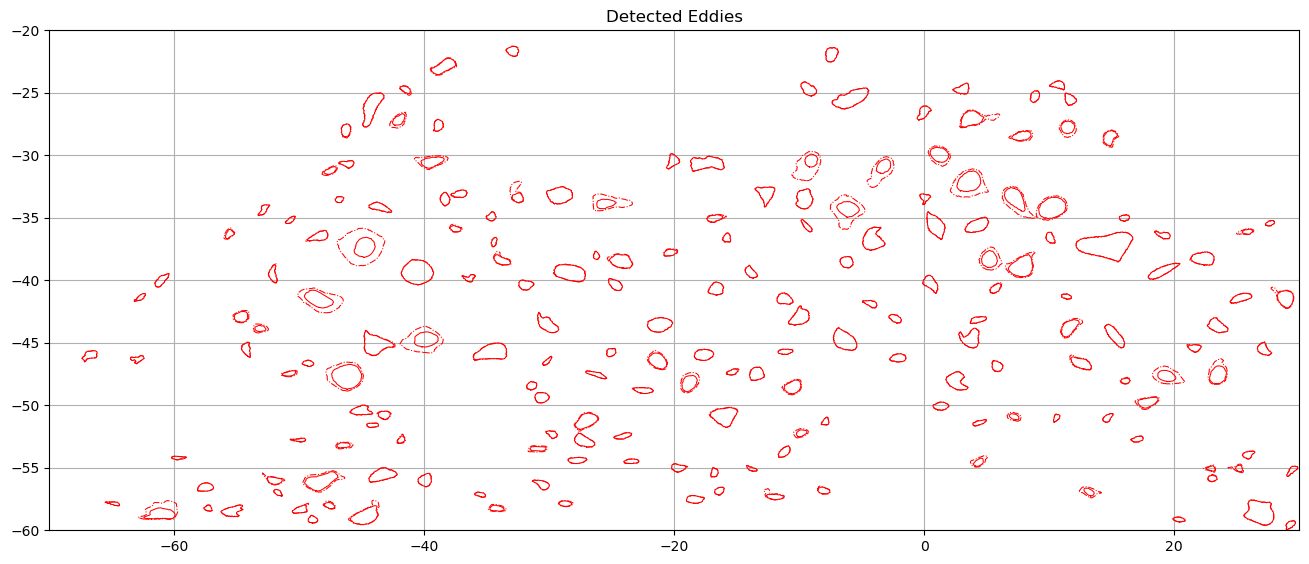

In [54]:
fig, ax = start_axes("Detected Eddies")
a_true.display(ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
#c_true.display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
#a_true.circle_contour()
#a_true.display(ax, color="g", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
update_axes(ax)

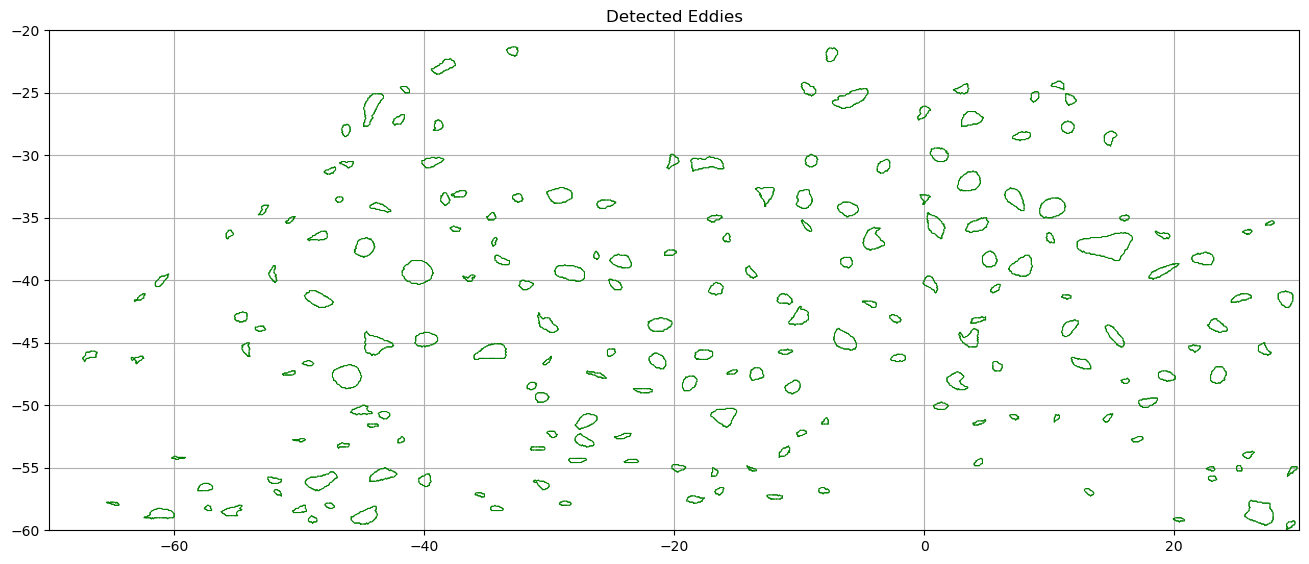

In [58]:
fig, ax = start_axes("Detected Eddies")
#a_true.display(ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
a_true_alg.display(ax, color="g", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
# a_true_alg.circle_contour()
# a_true_alg.display(ax, color="g", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
update_axes(ax)

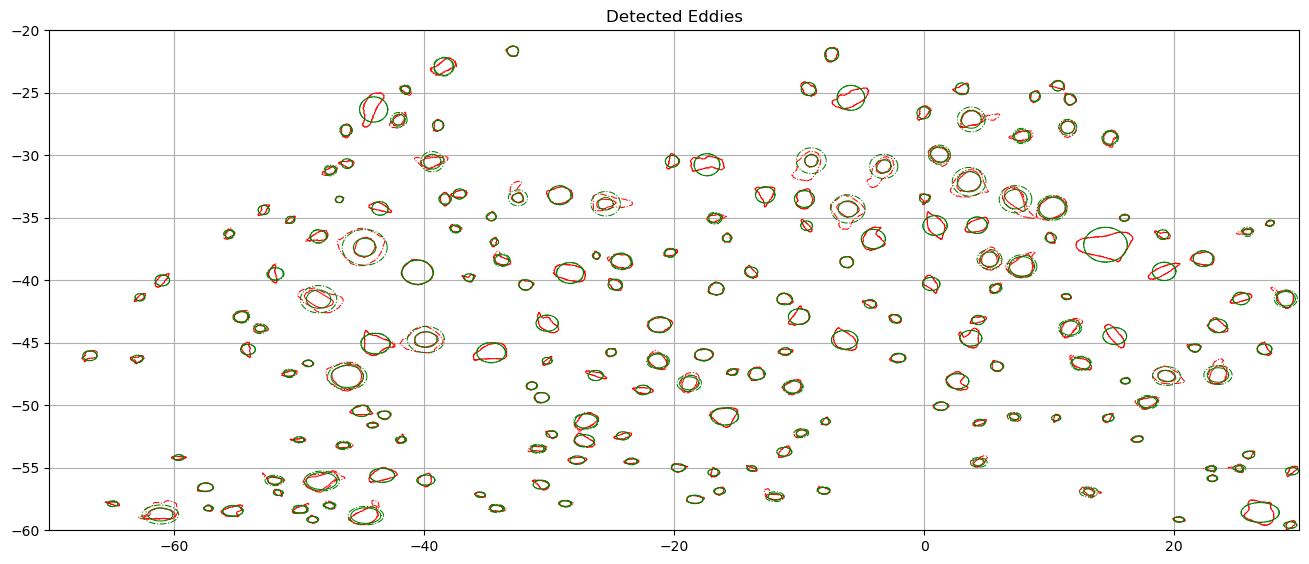

In [80]:
fig, ax = start_axes("Detected Eddies")
a_true.display(ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
#c_true.display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
a_true.circle_contour()
a_true.display(ax, color="g", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
update_axes(ax)

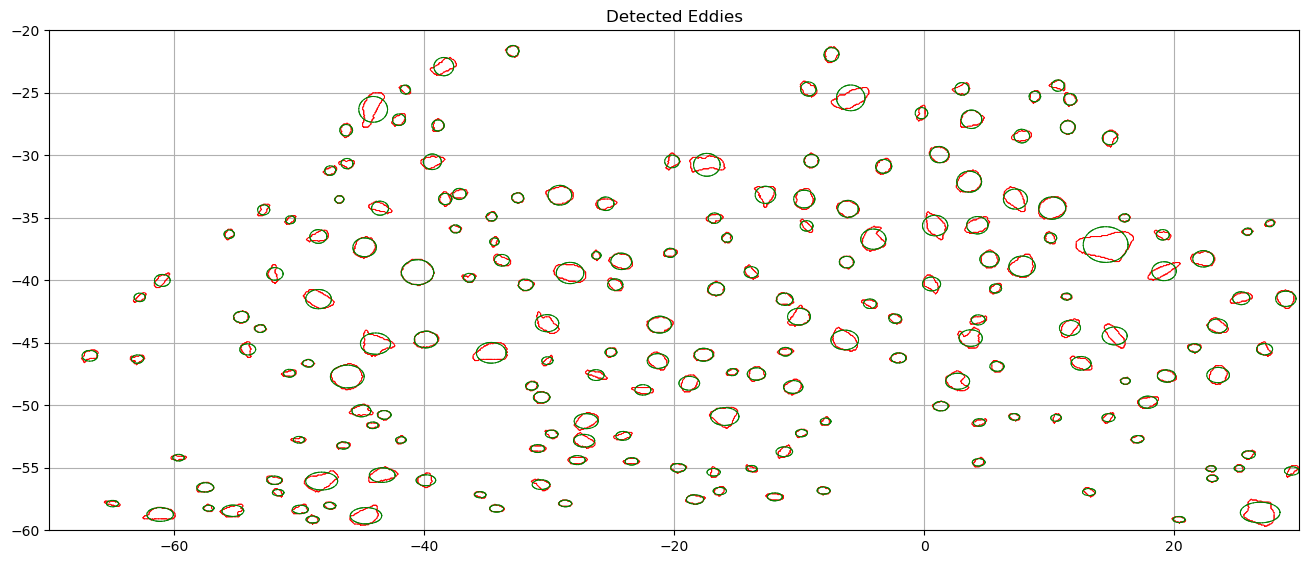

In [81]:
fig, ax = start_axes("Detected Eddies")
a_true_alg.display(ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
a_true_alg.circle_contour()
a_true_alg.display(ax, color="g", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
update_axes(ax)

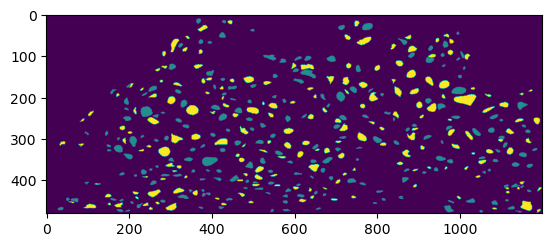

In [56]:
plt.imshow(np.flipud(seg_mask_true.T))

In [ ]:
#(0, 27) look the pixels for ref= -70
#No amp found thing (derivative of amp)
#soln check for -60 -20 lon
#pixel limit
#check histogram for amp, speed, and radius
#switch seg mask contour 0,1 -> 1,0 or invert mask


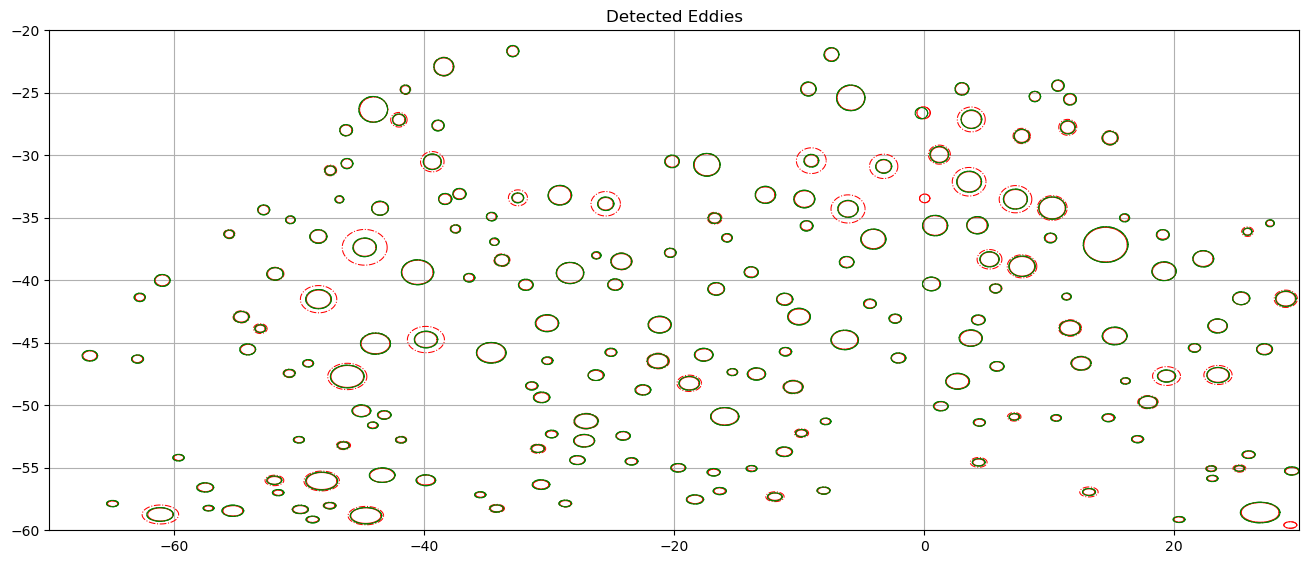

In [82]:
fig, ax = start_axes("Detected Eddies")
a_true.display(ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
#c_true.display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
a_true_alg.display(ax, color="g", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70)
#c_true_alg.display(ax, color="y", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
update_axes(ax)

In [11]:
print(a_true)
print("\n\n\n")
print(a_true_alg)

    | 191 observations from 4018.0 to 4018.0 (1.0 days, ~191 obs/day)
    |   Speed area      : 1.56 Mkm²/day
    |   Effective area  : 2.03 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :      25.65     22.51     19.37      7.33      6.28     10.99      7.85
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00     19.90     29.84     24.08     12.57     11.52      2.09      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00     13.09     34.55     18.85     13.09     11.52      8.90      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

/albedo/home/ssunar/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:264: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


In [53]:
a_true_alg.radius_e

array([ 91900.,  72550.,  30500.,  27200.,  61450.,  50750.,  37550.,
        25700.,  32400.,  28900.,  28450.,  29900.,  41500.,  35600.,
        27400.,  28100.,  31700.,  32450.,  31850.,  41800.,  79350.,
        43600.,  48750.,  37600.,  64950.,  28250.,  33700.,  37250.,
        38550.,  27950.,  25600.,  26750.,  33100.,  40500.,  33300.,
        29800.,  34750.,  43650.,  35550.,  32650.,  56800.,  28800.,
        29950.,  32950.,  39600.,  34550.,  32550.,  66700.,  29700.,
        79550.,  33950.,  29950.,  30100.,  36400.,  29800.,  38550.,
        53500.,  42400.,  54000.,  48000.,  57150.,  46750.,  61350.,
        37000.,  71300., 101150.,  28950.,  67950.,  54600.,  55200.,
        48300.,  35200.,  31650.,  43450.,  65750.,  60800.,  33650.,
        34500.,  37200.,  47950.,  45750.,  92250.,  57900.,  49700.,
        37000.,  94700.,  50150.,  38750.,  38550.,  87300.,  74150.,
        73750.,  79350.,  67600.,  75950.,  63000.,  35050.,  75150.,
        74600.,  414

In [29]:
a_true_alg.radius_e.all()

True

In [19]:
a_true.radius_s.size

139

In [18]:
a_true_alg.radius_s.size

139

In [123]:
qq = a_true.radius_s.copy()
pp = a_true_alg.radius_s.copy()
qq.sort()
pp.sort()


In [130]:
a_true.lon


array([1.31878920e+01, 2.03954792e+01, 2.52235508e+01, 2.59716702e+01,
       2.30625591e+01, 2.29713917e+01, 3.25809692e+02, 2.68879738e+01,
       2.92964306e+01, 3.31300201e+02, 1.70670319e+01, 3.29109283e+02,
       3.11086517e+02, 4.36655188e+00, 3.24499268e+02, 3.41668854e+02,
       3.29360596e+02, 3.32256104e+02, 1.47335653e+01, 3.12444092e+02,
       3.04700806e+02, 3.15338745e+02, 3.43642883e+02, 3.36587982e+02,
       2.95086212e+02, 3.30206207e+02, 3.02750092e+02, 3.10093872e+02,
       3.51967041e+02, 3.02502808e+02, 3.48069794e+02, 4.43326998e+00,
       3.08336182e+02, 3.20140137e+02, 3.08025909e+02, 3.40335419e+02,
       7.20970631e+00, 2.98903656e+02, 3.11808807e+02, 1.05609045e+01,
       2.94293251e+01, 3.43180237e+02, 3.16647247e+02, 3.13549561e+02,
       3.52118988e+02, 3.48816284e+02, 3.46210693e+02, 3.35916138e+02,
       3.50189911e+02, 3.18157990e+02, 3.32811035e+02, 3.32963531e+02,
       1.79092712e+01, 3.15884186e+02, 1.61129417e+01, 3.16821655e+02,
      

In [121]:
pp

array([ 91900.,  72550.,  30500.,  27200.,  61450.,  50750.,  37550.,
        25700.,  32400.,  28900.,  28450.,  29900.,  41500.,  35600.,
        27400.,  28100.,  31700.,  32450.,  31850.,  41800.,  79350.,
        43600.,  48750.,  37600.,  64950.,  28250.,  33700.,  37250.,
        38550.,  27950.,  25600.,  26750.,  33100.,  40500.,  33300.,
        29800.,  34750.,  43650.,  35550.,  32650.,  56800.,  28800.,
        29950.,  32950.,  39600.,  34550.,  32550.,  66700.,  29700.,
        79550.,  33950.,  29950.,  30100.,  36400.,  29800.,  38550.,
        53500.,  42400.,  54000.,  48000.,  57150.,  46750.,  61350.,
        37000.,  71300., 101150.,  28950.,  67950.,  54600.,  55200.,
        48300.,  35200.,  31650.,  43450.,  65750.,  60800.,  33650.,
        34500.,  37200.,  47950.,  45750.,  92250.,  57900.,  49700.,
        37000.,  94700.,  50150.,  38750.,  38550.,  87300.,  74150.,
        73750.,  79350.,  67600.,  75950.,  63000.,  35050.,  75150.,
        74600.,  414

In [111]:
sum([np.any(abs(a_true.radius_s - i) <= 500) for i in a_true_alg.radius_s])

173

In [36]:
np.any(a_true_alg.radius_e == 1)

False

In [74]:
a_true_alg.bins_stat("radius_e")[0]

133401

(array([ 0.,  0.,  0.,  0.,  0., 18., 24., 24., 17., 16., 18., 11., 14.,
         7.,  8.,  9.,  4.,  4.,  8.,  1.,  2.,  0.,  3.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155]),
 <BarContainer object of 31 artists>)

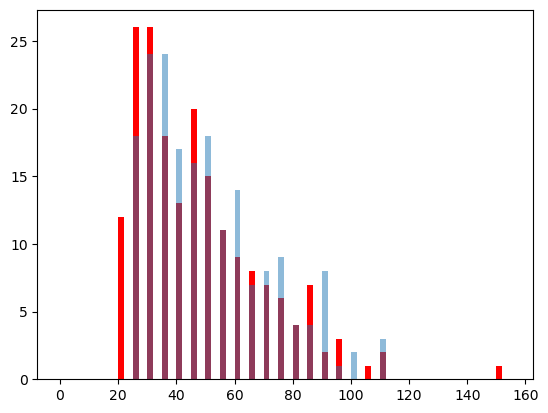

In [115]:
fig, ax = plt.subplots(1, 1)
ax.hist(a_true.radius_s/1000, bins = np.arange(0, 160, 5), width = 2, color = "r")
ax.hist(a_true_alg.radius_s/1000, bins = np.arange(0, 160, 5), width = 2, alpha = 0.5)

(array([22., 69., 43., 19., 12.,  9.,  3.,  6.,  0.,  0.,  2.,  1.,  2.,
         0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <BarContainer object of 19 artists>)

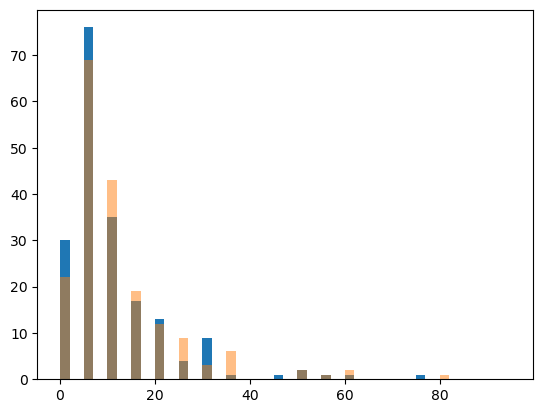

In [13]:
fig, ax = plt.subplots(1, 1)
ax.hist(a_true.speed_average*100, bins = np.arange(0, 100, 5), width = 2)
ax.hist(a_true_alg.speed_average*100, bins = np.arange(0, 100, 5), width = 2, alpha = 0.5)

(array([82., 58., 14., 17.,  2.,  7.,  2.,  2.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38]),
 <BarContainer object of 19 artists>)

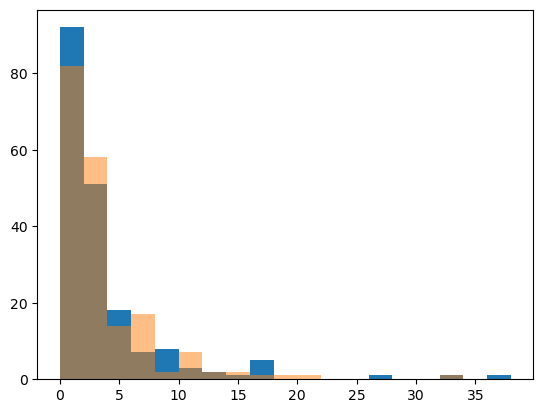

In [36]:
fig, ax = plt.subplots(1, 1)
ax.hist(a_true.amplitude*100, bins = np.arange(0, 40, 2), width = 2)
ax.hist(a_true_alg.amplitude*100, bins = np.arange(0, 40, 2), width = 2, alpha = 0.5)

(array([ 0.,  0., 18., 48., 33., 29., 21., 17.,  8.,  9.,  2.,  3.,  0.,
         0.,  0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150]),
 <BarContainer object of 15 artists>)

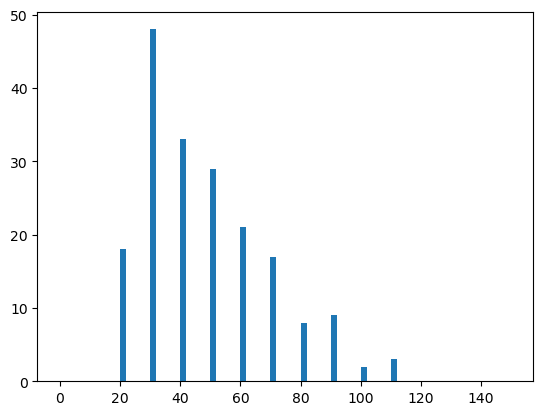

In [26]:
plt

In [14]:
(a_true.amplitude.mean() - a_true_alg.amplitude.mean()) * 100 #in cms

0.04115775227546692

In [13]:
a_true_alg.radius_e

array([ 91900.,  72550.,  30500.,  27200.,  61450.,  50750.,  37550.,
        25700.,  32400.,  28900.,  28450.,  29900.,  41500.,  35600.,
        27400.,  28100.,  31700.,  32450.,  31850.,  41800.,  79350.,
        43600.,  48750.,  37600.,  64950.,  28250.,  33700.,  37250.,
        38550.,  27950.,  25600.,  26750.,  33100.,  40500.,  33300.,
        29800.,  34750.,  43650.,  35550.,  32650.,  56800.,  28800.,
        29950.,  32950.,  39600.,  34550.,  32550.,  66700.,  29700.,
        79550.,  33950.,  29950.,  30100.,  36400.,  29800.,  38550.,
        53500.,  42400.,  54000.,  48000.,  57150.,  46750.,  61350.,
        37000.,  71300., 101150.,  28950.,  67950.,  54600.,  55200.,
        48300.,  35200.,  31650.,  43450.,  65750.,  60800.,  33650.,
        34500.,  37200.,  47950.,  45750.,  92250.,  57900.,  49700.,
        37000.,  94700.,  50150.,  38750.,  38550.,  87300.,  74150.,
        73750.,  79350.,  67600.,  75950.,  63000.,  35050.,  75150.,
        74600.,  414

In [8]:

print(a_true.radius_s.mean() - a_true_alg.radius_s.mean())

print(c_true.radius_s.mean() - c_true_alg.radius_s.mean())

3569.711
3463.4805
